In [ ]:
import numpy as np
import pandas as pd
import os
import joblib
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from img2vec import rgb2emb

### Load data

In [20]:
data_dir = os.path.join('..', '..', 'data')
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
val_data = pd.read_csv(os.path.join(data_dir, 'val.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))

### check if images exist and filter

In [21]:
def construct_img_path(row):
    return os.path.join(data_dir, 'faces', row['user_id'], 
                       f"coarse_tilt_aligned_face.{row['face_id']}.{row['original_image']}")

train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)

train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

# Filter to include only rows where images exist
train_data = train_data[train_data['img_exists'] == True]
val_data = val_data[val_data['img_exists'] == True]
test_data = test_data[test_data['img_exists'] == True]

### encode labels

In [22]:
if os.path.exists('age_encoder.pkl') and os.path.exists('gender_encoder.pkl'):
    age_encoder = joblib.load('age_encoder.pkl')
    gender_encoder = joblib.load('gender_encoder.pkl')
    print("Age and gender encoders loaded successfully.")
    
    # Add these lines to encode train data when loading existing encoders
    train_data['age_encoded'] = age_encoder.transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.transform(train_data['gender'])
else:
    # Remove rare classes
    age_counts = train_data['age'].value_counts()
    gender_counts = train_data['gender'].value_counts()
    rare_ages = age_counts[age_counts < 5].index.tolist()
    rare_genders = gender_counts[gender_counts < 5].index.tolist()
    
    # Filter data
    train_data = train_data[~train_data['age'].isin(rare_ages) & ~train_data['gender'].isin(rare_genders)]
    
    # Create encoders
    age_encoder = LabelEncoder()
    gender_encoder = LabelEncoder()
    train_data['age_encoded'] = age_encoder.fit_transform(train_data['age'])
    train_data['gender_encoded'] = gender_encoder.fit_transform(train_data['gender'])
    
    # Save encoders
    joblib.dump(age_encoder, 'age_encoder.pkl')
    joblib.dump(gender_encoder, 'gender_encoder.pkl')
    print("Encoders created and saved.")

# Filter validation and test data to include only seen classes
val_data = val_data[val_data['age'].isin(age_encoder.classes_)]
val_data = val_data[val_data['gender'].isin(gender_encoder.classes_)]
test_data = test_data[test_data['age'].isin(age_encoder.classes_)]
test_data = test_data[test_data['gender'].isin(gender_encoder.classes_)]

# Encode the labels
val_data['age_encoded'] = age_encoder.transform(val_data['age'])
val_data['gender_encoded'] = gender_encoder.transform(val_data['gender'])
test_data['age_encoded'] = age_encoder.transform(test_data['age'])
test_data['gender_encoded'] = gender_encoder.transform(test_data['gender'])

num_age_classes = len(age_encoder.classes_)
num_gender_classes = len(gender_encoder.classes_)
print(f"Age classes: {age_encoder.classes_}")
print(f"Gender classes: {gender_encoder.classes_}")


Encoders created and saved.
Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']
Gender classes: ['f' 'm' 'u']


### Define function that process features in batches and store them to avoid recomputation

In [23]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)

    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1}/{math.ceil(len(image_paths) / batch_size)}")
        batch_features = rgb2emb(batch_paths)
        all_features.append(batch_features)

    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [24]:
if not os.path.exists('train_features.npy'):
    train_features = preprocess_and_save_features(train_data['img_path'].tolist(), 'train_features.npy')
    val_features = preprocess_and_save_features(val_data['img_path'].tolist(), 'val_features.npy')
    test_features = preprocess_and_save_features(test_data['img_path'].tolist(), 'test_features.npy')
else:
    train_features = np.load('train_features.npy')
    val_features = np.load('val_features.npy')
    test_features = np.load('test_features.npy')


Processing 11856 images and saving to train_features.npy
Processing batch 1/186


Processing batch 2/186
Processing batch 3/186
Processing batch 4/186
Processing batch 5/186
Processing batch 6/186
Processing batch 7/186
Processing batch 8/186
Processing batch 9/186
Processing batch 10/186
Processing batch 11/186
Processing batch 12/186
Processing batch 13/186
Processing batch 14/186
Processing batch 15/186
Processing batch 16/186
Processing batch 17/186
Processing batch 18/186
Processing batch 19/186
Processing batch 20/186
Processing batch 21/186
Processing batch 22/186
Processing batch 23/186
Processing batch 24/186
Processing batch 25/186
Processing batch 26/186
Processing batch 27/186
Processing batch 28/186
Processing batch 29/186
Processing batch 30/186
Processing batch 31/186
Processing batch 32/186
Processing batch 33/186
Processing batch 34/186
Processing batch 35/186
Processing batch 36/186
Processing batch 37/186
Processing batch 38/186
Processing batch 39/186
Processing batch 40/186
Processing batch 41/186
Processing batch 42/186
Processing batch 43/186


### Standardize features

In [25]:
if os.path.exists('feature_scaler.pkl'):
    scaler = joblib.load('feature_scaler.pkl')
    print("Feature scaler loaded successfully.")
else:
    scaler = StandardScaler()
    scaler.fit(train_features)
    joblib.dump(scaler, 'feature_scaler.pkl')
    print("Feature scaler created and saved.")

train_features_scaled = scaler.transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

Feature scaler created and saved.


### Define model

In [26]:
def create_age_model(input_dim, num_age_classes):
    input_layer = Input(shape=(input_dim,))
    
    x = Dense(256, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    age_output = Dense(num_age_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=age_output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Gender prediction model
def create_gender_model(input_dim, num_gender_classes):
    input_layer = Input(shape=(input_dim,))
    
    x = Dense(256, activation='relu')(input_layer)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    gender_output = Dense(num_gender_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=gender_output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create models
age_model = create_age_model(train_features.shape[1], num_age_classes)
gender_model = create_gender_model(train_features.shape[1], num_gender_classes)

# Define callbacks for age model
age_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_age_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Define callbacks for gender model
gender_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_gender_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

### Compute class weights and get labels

In [27]:
train_age_labels = train_data['age_encoded'].values
train_gender_labels = train_data['gender_encoded'].values
val_age_labels = val_data['age_encoded'].values
val_gender_labels = val_data['gender_encoded'].values

age_weights = compute_class_weight('balanced', classes=np.unique(train_data['age_encoded']), 
                                  y=train_data['age_encoded'])
gender_weights = compute_class_weight('balanced', classes=np.unique(train_data['gender_encoded']), 
                                     y=train_data['gender_encoded'])

### Train models

In [28]:
print("Training the age model...")
age_history = age_model.fit(
    train_features_scaled,
    train_age_labels,
    validation_data=(val_features_scaled, val_age_labels),
    epochs=30,
    batch_size=64,
    callbacks=age_callbacks,
    class_weight=dict(enumerate(age_weights))
)

# Train gender model
print("Training the gender model...")
gender_history = gender_model.fit(
    train_features_scaled,
    train_gender_labels,
    validation_data=(val_features_scaled, val_gender_labels),
    epochs=30,
    batch_size=64,
    callbacks=gender_callbacks,
    class_weight=dict(enumerate(gender_weights))
)

Training the age model...
Epoch 1/30
183/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2620 - loss: 2.0862
Epoch 1: val_loss improved from inf to 1.30937, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2633 - loss: 2.0807 - val_accuracy: 0.4747 - val_loss: 1.3094
Epoch 2/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4072 - loss: 1.4482
Epoch 2: val_loss improved from 1.30937 to 1.17014, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4077 - loss: 1.4469 - val_accuracy: 0.5466 - val_loss: 1.1701
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4807 - loss: 1.2465
Epoch 3: val_loss improved from 1.17014 to 1.11215, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4807 - loss: 1.2464 - val_accuracy: 0.5634 - val_loss: 1.1122
Epoch 4/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5262 - loss: 1.1189
Epoch 4: val_loss improved from 1.11215 to 1.05784, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5261 - loss: 1.1191 - val_accuracy: 0.5874 - val_loss: 1.0578
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5529 - loss: 1.0549
Epoch 5: val_loss improved from 1.05784 to 1.03856, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5528 - loss: 1.0549 - val_accuracy: 0.5911 - val_loss: 1.0386
Epoch 6/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5792 - loss: 0.9797
Epoch 6: val_loss improved from 1.03856 to 1.00961, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5792 - loss: 0.9799 - val_accuracy: 0.6096 - val_loss: 1.0096
Epoch 7/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6012 - loss: 0.9302
Epoch 7: val_loss improved from 1.00961 to 0.97881, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6011 - loss: 0.9304 - val_accuracy: 0.6184 - val_loss: 0.9788
Epoch 8/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6065 - loss: 0.8918
Epoch 8: val_loss did not improve from 0.97881
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6064 - loss: 0.8921 - val_accuracy: 0.6164 - val_loss: 0.9834
Epoch 9/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6294 - loss: 0.8045
Epoch 9: val_loss improved from 0.97881 to 0.93665, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6292 - loss: 0.8050 - val_accuracy: 0.6404 - val_loss: 0.9367
Epoch 10/30
181/186 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6524 - loss: 0.7716
Epoch 10: val_loss improved from 0.93665 to 0.91910, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6521 - loss: 0.7722 - val_accuracy: 0.6555 - val_loss: 0.9191
Epoch 11/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6647 - loss: 0.7468
Epoch 11: val_loss improved from 0.91910 to 0.91712, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6645 - loss: 0.7470 - val_accuracy: 0.6518 - val_loss: 0.9171
Epoch 12/30
183/186 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6734 - loss: 0.7030
Epoch 12: val_loss did not improve from 0.91712
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6733 - loss: 0.7034 - val_accuracy: 0.6346 - val_loss: 0.9385
Epoch 13/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6903 - loss: 0.6661
Epoch 13: val_loss improved from 0.91712 to 0.91712, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6903 - loss: 0.6662 - val_accuracy: 0.6488 - val_loss: 0.9171
Epoch 14/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7025 - loss: 0.6277
Epoch 14: val_loss improved from 0.91712 to 0.91489, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7025 - loss: 0.6278 - val_accuracy: 0.6545 - val_loss: 0.9149
Epoch 15/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7153 - loss: 0.6083
Epoch 15: val_loss improved from 0.91489 to 0.91436, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7153 - loss: 0.6083 - val_accuracy: 0.6535 - val_loss: 0.9144
Epoch 16/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7123 - loss: 0.5894
Epoch 16: val_loss improved from 0.91436 to 0.90150, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7124 - loss: 0.5894 - val_accuracy: 0.6484 - val_loss: 0.9015
Epoch 17/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7212 - loss: 0.5664
Epoch 17: val_loss improved from 0.90150 to 0.89628, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7213 - loss: 0.5664 - val_accuracy: 0.6650 - val_loss: 0.8963
Epoch 18/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7451 - loss: 0.5255
Epoch 18: val_loss improved from 0.89628 to 0.88430, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7451 - loss: 0.5256 - val_accuracy: 0.6657 - val_loss: 0.8843
Epoch 19/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7473 - loss: 0.5120
Epoch 19: val_loss did not improve from 0.88430
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7473 - loss: 0.5122 - val_accuracy: 0.6707 - val_loss: 0.8880
Epoch 20/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7619 - loss: 0.4784
Epoch 20: val_loss improved from 0.88430 to 0.87869, saving model to best_age_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7619 - loss: 0.4784 - val_accuracy: 0.6835 - val_loss: 0.8787
Epoch 21/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7657 - loss: 0.4800
Epoch 21: val_loss did not improve from 0.87869
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7657 - loss: 0.4802 - val_accuracy: 0.6711 - val_loss: 0.8971
Epoch 22/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7797 - loss: 0.4509
Epoch 22: val_loss did not improve from 0.87869
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7796 - loss: 0.4510 - val_accuracy: 0.6657 - val_loss: 0.9165
Epoch 23/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7879 - loss: 0.4281
Epoch 23: val_loss did not improve from 0.87869
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7879 - loss: 0.4283 - val_accuracy: 0.6738 - val_loss: 0.9113
Epoch 24/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7968 - loss: 0.4033
Epoch 24: val_loss did not impro

186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6073 - loss: 0.8634 - val_accuracy: 0.8053 - val_loss: 0.5288
Epoch 2/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7867 - loss: 0.4558
Epoch 2: val_loss improved from 0.52879 to 0.42043, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7869 - loss: 0.4557 - val_accuracy: 0.8347 - val_loss: 0.4204
Epoch 3/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8200 - loss: 0.4005
Epoch 3: val_loss improved from 0.42043 to 0.38336, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8201 - loss: 0.4001 - val_accuracy: 0.8512 - val_loss: 0.3834
Epoch 4/30
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8459 - loss: 0.3244
Epoch 4: val_loss improved from 0.38336 to 0.33113, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8460 - loss: 0.3245 - val_accuracy: 0.8661 - val_loss: 0.3311
Epoch 5/30
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8681 - loss: 0.2953
Epoch 5: val_loss did not improve from 0.33113
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8681 - loss: 0.2954 - val_accuracy: 0.8650 - val_loss: 0.3406
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8740 - loss: 0.2875
Epoch 6: val_loss improved from 0.33113 to 0.30336, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8740 - loss: 0.2875 - val_accuracy: 0.8748 - val_loss: 0.3034
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8948 - loss: 0.2318
Epoch 7: val_loss did not improve from 0.30336
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8947 - loss: 0.2319 - val_accuracy: 0.8836 - val_loss: 0.3074
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9003 - loss: 0.2128
Epoch 8: val_loss did not improve from 0.30336
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9003 - loss: 0.2129 - val_accuracy: 0.8860 - val_loss: 0.3094
Epoch 9/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9039 - loss: 0.2073
Epoch 9: val_loss improved from 0.30336 to 0.29210, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9039 - loss: 0.2075 - val_accuracy: 0.8866 - val_loss: 0.2921
Epoch 10/30
183/186 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9117 - loss: 0.1858
Epoch 10: val_loss improved from 0.29210 to 0.27065, saving model to best_gender_model.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9117 - loss: 0.1860 - val_accuracy: 0.8988 - val_loss: 0.2707
Epoch 11/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9156 - loss: 0.1852
Epoch 11: val_loss did not improve from 0.27065
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9155 - loss: 0.1852 - val_accuracy: 0.8941 - val_loss: 0.2896
Epoch 12/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9204 - loss: 0.1758
Epoch 12: val_loss did not improve from 0.27065
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9204 - loss: 0.1759 - val_accuracy: 0.8900 - val_loss: 0.3038
Epoch 13/30
182/186 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9311 - loss: 0.1600
Epoch 13: val_loss did not improve from 0.27065
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9310 - loss: 0.1601 - val_accuracy: 0.8930 - val_loss: 0.3075
Epoch 14/30
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9330 - loss: 0.1499
Epoch 14: val_loss did not impro

### Save the model

In [29]:
age_model.save('age_model.h5')
gender_model.save('gender_model.h5')
print("Models saved successfully.")

Models saved successfully.


### Evaluate the model

In [30]:
# After training the separate models, we can evaluate them together:
print("Evaluating models together...")

# Make predictions with both models
age_predictions = np.argmax(age_model.predict(test_features_scaled), axis=1)
gender_predictions = np.argmax(gender_model.predict(test_features_scaled), axis=1)

# Calculate individual accuracies
age_accuracy = np.mean(age_predictions == test_data['age_encoded'].values)
gender_accuracy = np.mean(gender_predictions == test_data['gender_encoded'].values)

# Calculate combined accuracy (both predictions correct)
correct_both = np.logical_and(
    age_predictions == test_data['age_encoded'].values,
    gender_predictions == test_data['gender_encoded'].values
)
combined_accuracy = np.mean(correct_both)

print(f"Age Accuracy: {age_accuracy:.4f}")
print(f"Gender Accuracy: {gender_accuracy:.4f}")
print(f"Combined Accuracy (both correct): {combined_accuracy:.4f}")

Evaluating models together...
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Age Accuracy: 0.3876
Gender Accuracy: 0.8143
Combined Accuracy (both correct): 0.3149


### Make predictions

In [31]:
print("Making predictions...")
age_predictions = np.argmax(age_model.predict(test_features_scaled), axis=1)
gender_predictions = np.argmax(gender_model.predict(test_features_scaled), axis=1)

Making predictions...
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Generate classification reports 

In [32]:
print("\nAge Classification Report:")
print(classification_report(test_data['age_encoded'].values, age_predictions, 
                          target_names=age_encoder.classes_))
print("\nGender Classification Report:")
print(classification_report(test_data['gender_encoded'].values, gender_predictions, 
                          target_names=gender_encoder.classes_))


Age Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.73      0.73      0.73       483
    (15, 20)       0.14      0.21      0.17       227
    (25, 32)       0.49      0.44      0.46      1036
    (38, 43)       0.25      0.29      0.27       543
      (4, 6)       0.50      0.35      0.41       570
    (48, 53)       0.19      0.17      0.18       258
   (60, 100)       0.45      0.35      0.40       274
     (8, 23)       0.19      0.29      0.23       340

    accuracy                           0.39      3731
   macro avg       0.37      0.35      0.35      3731
weighted avg       0.42      0.39      0.40      3731


Gender Classification Report:
              precision    recall  f1-score   support

           f       0.85      0.82      0.83      1848
           m       0.79      0.83      0.81      1597
           u       0.73      0.70      0.72       286

    accuracy                           0.81      3731
   macro avg      

### visualize training history

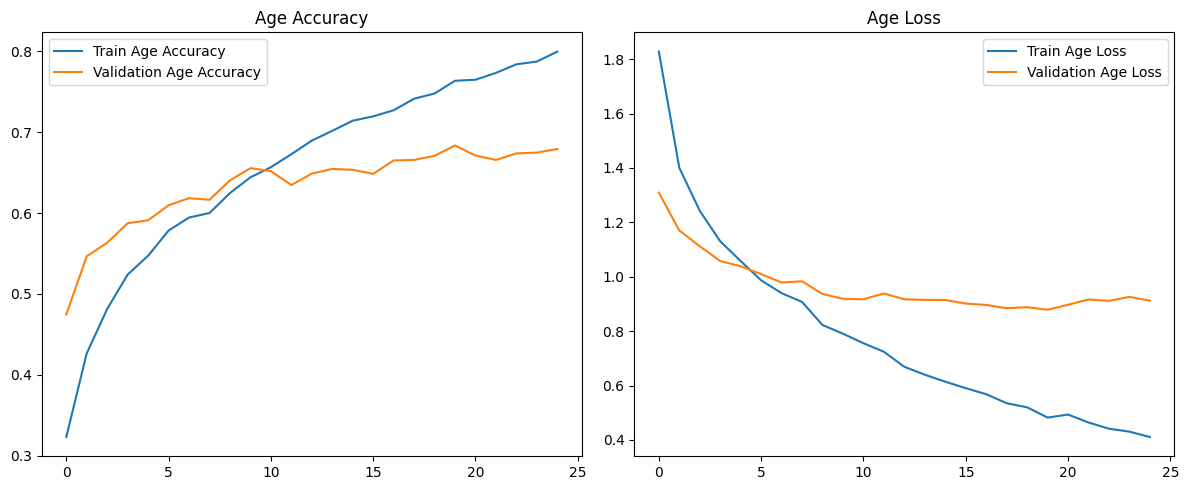

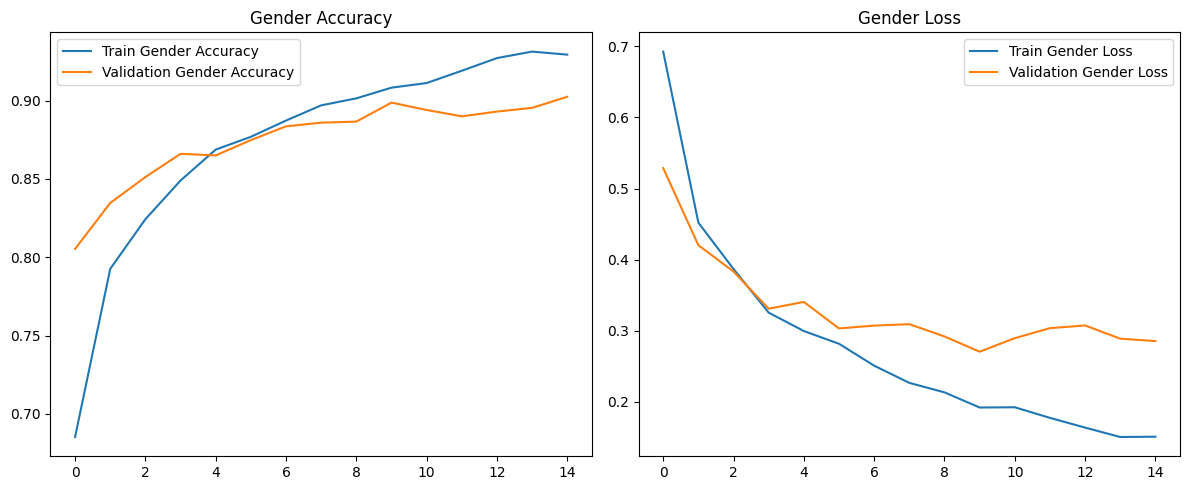

In [33]:
plt.figure(figsize=(12, 5))

# Age accuracy
plt.subplot(1, 2, 1)
plt.plot(age_history.history['accuracy'], label='Train Age Accuracy')
plt.plot(age_history.history['val_accuracy'], label='Validation Age Accuracy')
plt.title('Age Accuracy')
plt.legend()

# Age loss
plt.subplot(1, 2, 2)
plt.plot(age_history.history['loss'], label='Train Age Loss')
plt.plot(age_history.history['val_loss'], label='Validation Age Loss')
plt.title('Age Loss')
plt.legend()

plt.tight_layout()
plt.savefig('age_training_history.png')
plt.show()

# Visualize training history for gender model
plt.figure(figsize=(12, 5))

# Gender accuracy
plt.subplot(1, 2, 1)
plt.plot(gender_history.history['accuracy'], label='Train Gender Accuracy')
plt.plot(gender_history.history['val_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.legend()

# Gender loss
plt.subplot(1, 2, 2)
plt.plot(gender_history.history['loss'], label='Train Gender Loss')
plt.plot(gender_history.history['val_loss'], label='Validation Gender Loss')
plt.title('Gender Loss')
plt.legend()

plt.tight_layout()
plt.savefig('gender_training_history.png')
plt.show()

### Example of how to load the model and use it for prediction

In [34]:
def predict_age_and_gender(image_path):
    """
    Load pre-trained models and predict age and gender from an image.
    
    Args:
        image_path (str): Path to the image file
    
    Returns:
        tuple: (age_range, gender) as strings
    """
    import numpy as np
    import os
    import joblib
    from tensorflow.keras.models import load_model
    from img2vec import rgb2emb  # Your feature extraction function
    
    # Check if the image exists
    if not os.path.exists(image_path):
        return "Error: Image not found"
    
    # Load the models
    try:
        age_model = load_model('age_model.h5')
        gender_model = load_model('gender_model.h5')
    except Exception as e:
        return f"Error loading models: {str(e)}"
    
    # Load the encoders
    try:
        age_encoder = joblib.load('age_encoder.pkl')
        gender_encoder = joblib.load('gender_encoder.pkl')
        scaler = joblib.load('feature_scaler.pkl')
    except Exception as e:
        return f"Error loading encoders: {str(e)}"
    
    # Extract features from the image
    try:
        # Convert to batch format (list with single image)
        features = rgb2emb([image_path])
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        # Make predictions
        age_pred = np.argmax(age_model.predict(features_scaled), axis=1)[0]
        gender_pred = np.argmax(gender_model.predict(features_scaled), axis=1)[0]
        
        # Convert numerical predictions to original labels
        age_range = age_encoder.inverse_transform([age_pred])[0]
        gender = gender_encoder.inverse_transform([gender_pred])[0]
        
        return (age_range, gender)
    
    except Exception as e:
        return f"Error during prediction: {str(e)}"

# Example usage:
age_range, gender = predict_age_and_gender("../../img.jpg")
print(f"Predicted Age Range: {age_range}")
print(f"Predicted Gender: {gender}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted Age Range: (25, 32)
Predicted Gender: m
